# Predicting Unlabelled Objects

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from mclearn.classifier import train_classifier, predict_unlabelled_objects
%matplotlib inline
plt.style.use('ggplot')

In [3]:
sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
fig_dir = '../thesis/figures/'
target_col = 'class'
feature_cols = ['ra', 'dec', 'psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11', 'psfMag_i_sf11',
                'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11',
                'petroMag_u_sf11', 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

Here's the confusion matrix:


Predicted              
                 Galaxy Quasar   Star
Actual Galaxy     97685   1768    547
       Quasar      2704  93182   4114
       Star        1206   8681  90113

The balanced accuracy rate is 93.66%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9615    0.9768    0.9691    100000
       Star     0.9508    0.9011    0.9253    100000
     Quasar     0.8992    0.9318    0.9152    100000

avg / total     0.9372    0.9366    0.9365    300000

Recall Maps of Galaxies, Stars, and Quasars, respectively:


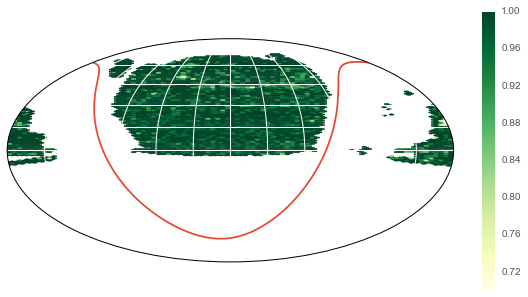

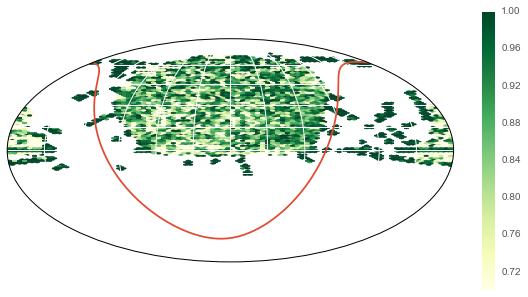

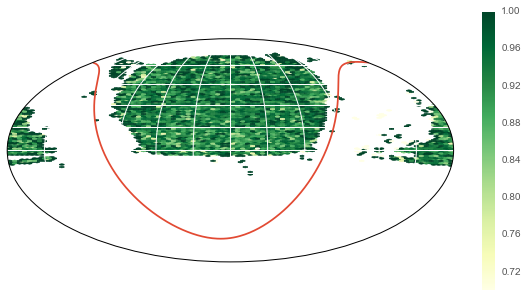

In [4]:
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='subsample', random_state=6)
forest, confusion = train_classifier(sdss, feature_cols, target_col, train_size=279000,
    test_size=100000, output='forest_class', random_state=14, classifier=forest, balanced=True,
    returns=['classifier', 'confusion_test'], pickle_path='../pickle/06_predicting_unlabelled_objects/forest_class.pickle')

Total number of objects: 794014031
Number of predicted as galaxies: 389,215,078 (49.0%)
Number of predicted as quasars: 138,553,601 (17.4%)
Number of predicted as stars: 266,245,352 (33.5%)


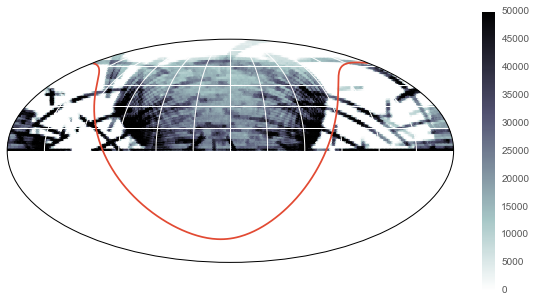

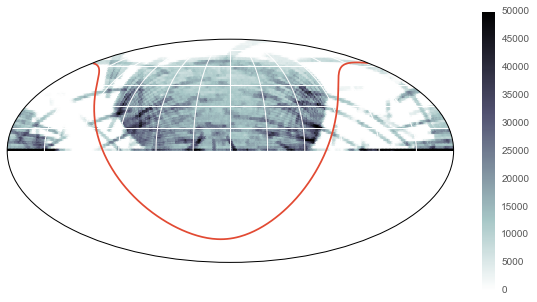

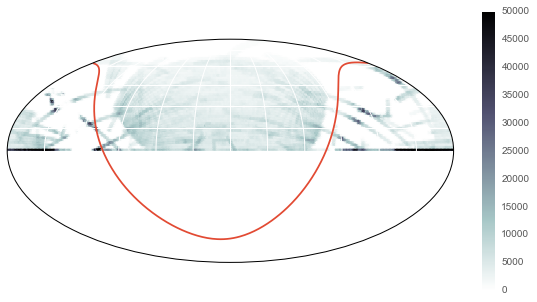

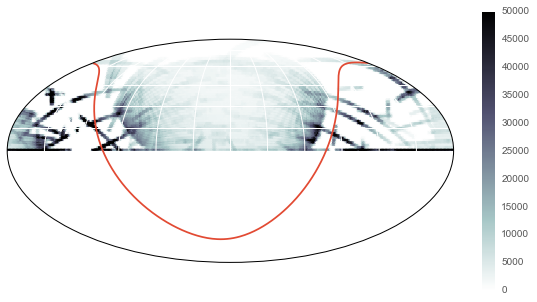

In [26]:
with open('../pickle/06_predicting_unlabelled_objects/forest_class.pickle', 'rb') as f:
    forest = pickle.load(f)
    
data_cols = ['ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'petroMag_u',
             'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'extinction_u', 'extinction_g',
             'extinction_r', 'petroRad_r']

feature_cols = ['psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11', 'psfMag_i_sf11',
                'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11',
                'petroMag_u_sf11', 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

pickle_paths = ['../pickle/06_predicting_unlabelled_objects/galaxy_map.pickle',
                '../pickle/06_predicting_unlabelled_objects/quasar_map.pickle',
                '../pickle/06_predicting_unlabelled_objects/star_map.pickle']

fig_paths = [fig_dir + 'map_prediction_forest_all.png',
             fig_dir + 'map_prediction_forest_galaxies.png',
             fig_dir + 'map_prediction_forest_quasars.png',
             fig_dir + 'map_prediction_forest_stars.png']

targets = ['Galaxy', 'Quasar', 'Star']

predict_unlabelled_objects('data/sdss_full.h5', 'sdss_full', classifier=forest, data_cols=data_cols,
    feature_cols=feature_cols, chunksize=50000, targets=targets, pickle_paths=pickle_paths, fig_paths=fig_paths)

Let's now correct for the class proportion. First we construct the normalised confusion matrix.

In [29]:
# order: galaxy, quasar star
confusion_matrix = np.array([
    [97685, 1768, 547],
    [2704, 93182, 4114],
    [1206, 8681, 90113],
])		

class_total = confusion_matrix.sum(axis=1)
class_total = np.tile(class_total, (3, 1)).transpose()
normalised_confusion = confusion_matrix / class_total
normalised_confusion

# put normalised confusion matrix in a DataFrame
classes = ['Galaxies', 'Quasars', 'Stars']
pred_index = pd.MultiIndex.from_tuples(list(zip(['Predicted'] * 3, classes)))
act_index = pd.MultiIndex.from_tuples(list(zip(['Actual'] * 3, classes)))
confusion_features_df = pd.DataFrame(normalised_confusion, columns=pred_index, index=act_index)

# display results
print('Here\'s the normalised confusion matrix:')
confusion_features_df.applymap(lambda x: '{:.1%}'.format(x))

Here's the normalised confusion matrix:


Predicted               
                 Galaxies Quasars  Stars
Actual Galaxies     97.7%    1.8%   0.5%
       Quasars       2.7%   93.2%   4.1%
       Stars         1.2%    8.7%  90.1%

Let's now correct for the potential misclassification.

In [30]:
corrected_galaxies = int(normalised_confusion[0][0] * total_galaxies + \
                         normalised_confusion[0][1] * total_quasars + \
                         normalised_confusion[0][2] * total_stars)

corrected_quasars = int(normalised_confusion[1][0] * total_galaxies + \
                        normalised_confusion[1][1] * total_quasars + \
                        normalised_confusion[1][2] * total_stars)

corrected_stars = int(normalised_confusion[2][0] * total_galaxies + \
                      normalised_confusion[2][1] * total_quasars + \
                      normalised_confusion[2][2] * total_stars)

print('Adjusted number of predicted as galaxies: {:,} ({:.1%})'.format(corrected_galaxies, corrected_galaxies/total))
print('Adjusted number of predicted as quasars: {:,} ({:.1%})'.format(corrected_quasars, corrected_quasars/total))
print('Adjusted number of predicted as stars: {:,} ({:.1%})'.format(corrected_stars, corrected_stars/total))

Adjusted number of predicted as galaxies: 384,110,738 (48.4%)
Adjusted number of predicted as quasars: 150,584,725 (19.0%)
Adjusted number of predicted as stars: 256,643,445 (32.3%)
